### Ergodic Search

*Date: June 10th, 2025*, *Author: Jared Berry*

The simulation environment was created by Max Muchen Sun, as a project template for MECH_ENG 455: Active Learning. It contains a sensor agent (robot) with 2d single integrator dynamics (controlled by velocity), a randomly generated box hidden from the robot, and a built-in prediction function that utilizes generative modeling techniques to predict possible box locations and dimensions given sensor reading history.

This notebook contains the code that defines the behavior of the agent searching for the box target. The main algorithm is ergodic search, which is performed with iLQR. The agent takes binary samples within the sensor bounds, with a positive reading signifying the presence of the hidden box and a negative reading showing the opposite. After receiving a certain threshold of positive readings, the agent then switches to an information maximization approach to eliminate uncertaity in the box's edges.

In [ ]:
# Download the box_gym environment code
!curl -o box_gym.py https://raw.githubusercontent.com/MurpheyLab/ME455_public/refs/heads/main/box_gym_project/box_gym.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13174  100 13174    0     0  77126      0 --:--:-- --:--:-- --:--:-- 77494


In [ ]:
# Import regular packages
import numpy as np
np.set_printoptions(precision=4)
np.seterr(divide='ignore', invalid='ignore')
import time
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import solve_bvp
from scipy.stats import multivariate_normal

# Import the playground environment
from box_gym import BoxGymBase

#### Plan:

Step 1: Check positive sensor reading threshold and determine search state.

Step 2: Turn predicted boxes into a "target" distribution
      
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a: Use negative/positive sensor readings (based on search state)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;b: Create pdf based on sample locations with Kernel Density Estimation (KDE)

Step 3: Recalculate Fourier coefficients of target distribution

Step 4: Plan control signal for next time step based on search state
      
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a: Positive sensor reading threshold not reached

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;i. If an ergodic trajectory isn't already planned, use iLQR to plan one. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ii. If ergodic trajectory is planned, follow it.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;b: Positive sensor reading threshold reached

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;i. If trajectory isn't planned, plan route to corner with most amount of variance in
               its possible location.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ii. If trajectory is planned, follow it.

Step 5: Save planned control signal and send to gym simulation function.

In [ ]:
class iLQR():
  """
  Define a class-based Iterative Linear Quadratic Regulator (iLQR).
  """
  def __init__(self, targ_dis, dt, dx, dy, T, x0, Q_x, R_u, P1, Q_z, R_v,
               L_list, grids, max_vel, max_iter=50, u_traj_prior=None, use_barrier=True, bgain=20.0, debug=False):
    # Input parameters
    self.targ_dis = targ_dis
    self.dt = dt
    self.dx = dx
    self.dy = dy
    self.T = T
    self.x0 = x0
    self.Q_x = Q_x
    self.R_u = R_u
    self.P1 = P1
    self.Q_z = Q_z
    self.R_v = R_v
    self.L_list = L_list
    self.grids = grids
    self.max_vel = max_vel
    self.max_iter = max_iter
    self.use_barrier = use_barrier
    self.bgain = bgain
    self.debug = debug

    # Simulation parameters and initialization
    self.tsteps = int(T/dt)
    self.n_dim = x0.shape[0]
    if u_traj_prior is not None:
      self.init_u_traj = u_traj_prior
    else:
      self.init_u_traj = np.tile(np.array([0.0, 0.0]), reps=(self.tsteps,1))

    #
    # Ergodic Metric Calculation
    #
    # Fourier index vectors: 10 coefficients per dimension (100 index vectors total)
    num_k_per_dim = 10
    ks_dim1, ks_dim2 = np.meshgrid(
        np.arange(num_k_per_dim),
        np.arange(num_k_per_dim)
    )
    self.ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T  # Set of index vectors
    self.lamk_list = np.power(1.0 + np.linalg.norm(self.ks, axis=1), -3/2.0)

    return

  # Dynamics are just control signal
  def dyn(self, xt, ut):
      return ut

  # Functions to evaluate dynamics jacobians
  def get_A(self, t, xt, ut):
    A = np.array([[0.0, 0.0],
                  [0.0, 0.0]])
    return A
  def get_B(self, t, xt, ut):
    B = np.array([[1.0, 0.0],
                  [0.0, 1.0]])
    return B

  # RK4 integrator step and simulator
  def step(self, xt, ut):
    k1 = self.dyn(xt, ut) * self.dt
    k2 = self.dyn(xt + 0.5*k1, ut) * self.dt
    k3 = self.dyn(xt + 0.5*k2, ut) * self.dt
    k4 = self.dyn(xt + k3, ut) * self.dt
    return xt + self.dt*(k1/6.0 + k2/3.0 + k3/3.0 + k4/6.0)
  def traj_sim(self, x0, ulist):
    tsteps = ulist.shape[0]
    x_ret = np.zeros((tsteps, x0.shape[0]))
    xt = x0.copy()
    for t in range(tsteps):
        x_ret[t] = xt.copy()
        if t < tsteps-1: xt = self.step(xt, ulist[t])
    return x_ret

  # Add penalty for any x out of bounds
  def barrier(self, x):
    return self.bgain*np.sum(np.maximum(0, x - self.L_list[0])**2 + np.minimum(0, x - 0)**2)
  def barrier_grad(self, x):
    # Upper bound gradient
    grad = np.zeros_like(x)
    over = x > self.L_list[0]
    grad[over] = 2 * (x[over] - self.L_list[0])

    # Lower bound gradient
    under = x < 0
    grad[under] = 2 * (x[under] - 0)

    return self.bgain*grad

  # Compute Fourier coefficients of target distribution
  def target_coefficients(self):
    # Evaluate basis functions
    fk_vals_tensor = np.cos(np.pi * self.ks[:,np.newaxis] / self.L_list * self.grids)

    # Compute normalization terms for each index vector
    self.hk_list = np.sqrt(np.sum(np.square(np.prod(fk_vals_tensor, axis=2)), axis=1) * self.dx * self.dy)

    # Compute coefficients
    self.targ_coefficients = np.sum(self.targ_dis * np.prod(fk_vals_tensor, axis=2) / self.hk_list[:,np.newaxis], axis=1) * self.dx * self.dy
    return

  # Calculate ergodicic metric, representing coverage of trajectory vs
  # target distribution. Also calculate regularization term.
  def loss_sim(self, x_traj, u_traj):
    # Ergodicity is a spatial metric, so we only need the states x and y: x_traj[:,:2]
    # Compute the basis function values for each index vector
    fk_vals_tensor = np.cos(np.pi * self.ks[:,np.newaxis] / self.L_list * x_traj[:,:2])

    # Compute the coefficients
    traj_coefficients = np.sum(np.prod(fk_vals_tensor, axis=2) / self.hk_list[:,np.newaxis], axis=1) * self.dt / (self.tsteps * self.dt)

    # Calculate ergodic metric
    erg_metric = np.sum(self.lamk_list * np.square(self.targ_coefficients - traj_coefficients))

    # Calculate regularization term
    reg = np.sum((self.R_u @ u_traj.T) * u_traj.T) * self.dt

    if self.use_barrier:
      barrier_penalty = np.sum([self.barrier(x) for x in x_traj[:,:2]]) * self.dt
      return erg_metric + reg + barrier_penalty
    else:
      return erg_metric + reg

  # Derivative of lagrangian w.r.t state
  def dldx(self, t, t_idx, x_traj, u_traj):
    xt = x_traj[t_idx]

    # Compute the basis function values for each index vector
    fk_vals_tensor = np.cos(np.pi * self.ks[:,np.newaxis] / self.L_list * x_traj[:,:2])

    # Compute the coefficients
    traj_coefficients = np.sum(np.prod(fk_vals_tensor, axis=2) / self.hk_list[:,np.newaxis], axis=1) * self.dt / (self.tsteps * self.dt)

    # Compute gradient of each basis function

    Dfk = np.array([
        -(np.pi*self.ks[:,0] / self.L_list[0]) * np.sin(np.pi*self.ks[:,0] / self.L_list[0] * xt[0]) * np.cos(np.pi*self.ks[:,1] / self.L_list[1] * xt[1]),
        -(np.pi*self.ks[:,1] / self.L_list[1]) * np.sin(np.pi*self.ks[:,1] / self.L_list[1] * xt[1]) * np.cos(np.pi*self.ks[:,0] / self.L_list[0] * xt[0])
    ]).T
    Dfk /= self.hk_list[:,np.newaxis]

    # Compute final vector
    at = np.zeros(self.n_dim)
    at[:2] = np.sum((self.lamk_list*2*(traj_coefficients - self.targ_coefficients))[:,np.newaxis] * Dfk/(self.tsteps * self.dt), axis=0)

    if self.use_barrier:
      Dbarrier = np.zeros(self.n_dim)
      Dbarrier[:2] = self.barrier_grad(xt[:2])
      return at + Dbarrier
    else:
      return at

  # Derivative of Lagrangian w.r.t control
  def dldu(self, t, xt, ut):
    return (ut @ self.R_u)

  # Compute loss derivative for Armijo line search
  def Dloss(self, x_traj, z_traj, u_traj, v_traj, armijo=False):
    xd_T = np.zeros((self.n_dim,))
    DJu_vt = 0
    # For line search, we compute DJ((x,u) dot (z,v))
    if armijo:
      # When using Armijo line search, x_dloss and u_dloss are the perturbed trajectories
      x_dloss = x_traj + z_traj
      u_dloss = u_traj + v_traj
    else:
      # When not using Armijo, x_dloss and u_dloss are the original trajectories
      x_dloss = x_traj
      u_dloss = u_traj

    for t_idx in range(self.tsteps):
        at = self.dldx(t_idx*self.dt, t_idx, x_dloss, u_dloss)
        bt = self.dldu(t_idx*self.dt, x_dloss[t_idx], u_dloss[t_idx])
        DJu_vt += 2*(at @ z_traj[t_idx]) + 2*(bt @ v_traj[t_idx])

    # Terminal cost derivative
    DJu_vt += 2*((self.P1 @ (x_traj[-1] - xd_T)) @ z_traj[-1])
    return DJu_vt

  def ilqr_iter(self, x0, u_traj):
    """
    Performs one iteration of the iLQR algorithm

    :param x0: initial state of the system
    :param u_traj: current estimation of the optimal control trajectory
    :return: the descent direction for the control
    """
    # Forward simulate the state trajectory
    x_traj = self.traj_sim(x0, u_traj)

    # Compute other variables needed for specifying the dynamics of z(t) and p(t)
    # at every point in time
    A_list = np.zeros((self.tsteps, self.n_dim, self.n_dim))
    B_list = np.zeros((self.tsteps, self.n_dim, u_traj[0].shape[0]))
    a_list = np.zeros((self.tsteps, self.n_dim))
    b_list = np.zeros((self.tsteps, u_traj[0].shape[0]))

    for t_idx in range(self.tsteps):
        t = t_idx * self.dt
        A_list[t_idx] = self.get_A(t, x_traj[t_idx], u_traj[t_idx])
        B_list[t_idx] = self.get_B(t, x_traj[t_idx], u_traj[t_idx])
        a_list[t_idx] = self.dldx(t, t_idx, x_traj, u_traj)
        b_list[t_idx] = self.dldu(t, x_traj[t_idx], u_traj[t_idx])

    xd_T = np.zeros((self.n_dim,))  # Desired terminal state
    p1 = 2*(self.P1 @ (x_traj[-1, :] - xd_T))     # Terminal condition p(T)

    # Function for z and p dynamics
    def zp_dyn(t, zp):
        t_idx = (t/self.dt).astype(int)
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]

        M_11 = At
        M_12 = -0.5*Bt @ np.linalg.inv(self.R_v) @ Bt.T
        M_21 = -2*self.Q_z
        M_22 = -At.T
        dyn_mat = np.block([
            [M_11, M_12],
            [M_21, M_22]
        ])

        m_1 = -0.5*Bt @ np.linalg.inv(self.R_v) @ bt
        m_2 = -at
        dyn_vec = np.hstack([m_1, m_2])

        return dyn_mat @ zp + dyn_vec

    # The actual dynamics function to provide to solve_bvp,
    # it takes in a list of time steps and corresponding [z(t), p(t)]
    # and returns a list of [zdot(t), pdot(t)]
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((2*self.n_dim, list_len))
        for _i in range(list_len):
            zp_dot_list[:,_i] = zp_dyn(t_list[_i], zp_list[:,_i])
        return zp_dot_list

    # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
    def zp_bc(zp_0, zp_T):
        return np.hstack([zp_0[0:self.n_dim], zp_T[self.n_dim:] - p1])

    ### The solver will say it does not converge, but the returned result
    ### is numerically accurate enough for our use
    initial_traj = np.zeros((2*self.n_dim,self.tsteps))
    tlist = np.arange(self.tsteps) * self.dt
    # initial_traj = np.repeat(np.array([1, -0.5]), tsteps).reshape(tsteps, 2)
    res = solve_bvp(zp_dyn_list, zp_bc, tlist, initial_traj, max_nodes=100)
    zp_traj = res.sol(tlist).T

    z_traj = zp_traj[:,:self.n_dim]
    p_traj = zp_traj[:,self.n_dim:]

    v_traj = np.zeros((self.tsteps, u_traj[0].shape[0]))

    # Solve for v from p
    for _i in range(self.tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_traj[_i]
        pt = p_traj[_i]

        vt = -0.5*(np.linalg.inv(self.R_v) @ ((Bt.T @ pt) + bt))
        v_traj[_i] = vt

    return z_traj, v_traj

  # Main iLQR simulation function
  def sim_iLQR(self):
    # Start iLQR iterations here
    u_traj = self.init_u_traj.copy()
    loss_tol = 1e-1

    # Calculate Fourier coefficients of target distribution
    self.target_coefficients()

    gam_tol = 1e-4
    iter = 0
    J_traj = []
    v_traj_prev = np.zeros((self.tsteps, 2))
    for _i in range(self.max_iter):
        if self.debug: print(f'\nIteration {iter}')
        # Forward simulate the current trajectory
        x_traj = self.traj_sim(self.x0, u_traj)

        # Get descent direction
        z_traj, v_traj = self.ilqr_iter(self.x0, u_traj)
        if self.debug: print("v_traj norm:", np.linalg.norm(v_traj))
        if self.debug: print("v_traj difference", np.linalg.norm(v_traj - v_traj_prev))
        v_traj_prev = v_traj

        # Armijo line search parameters
        gam = 0.1
        alpha = 1e-04
        beta = 0.5

        # Simulate loss and Dloss
        loss_curr = self.loss_sim(x_traj, u_traj)
        J_traj.append(loss_curr)
        Dloss_curr = self.Dloss(x_traj, z_traj, u_traj, v_traj, armijo=True)
        if self.debug: print('Loss: ', loss_curr)
        if self.debug: print('Dloss: ', Dloss_curr)

        # Armijo line search
        for i in range(10):
          # Resimulate with perturbation
          u_test = u_traj + gam*v_traj
          x_test = self.traj_sim(self.x0, u_test)
          loss_test = self.loss_sim(x_test, u_test)

          # Check armijo condition
          #fin_term = alpha*gam*Dloss_curr
          if loss_test <= loss_curr:# + fin_term:
            if self.debug: print('Armijo Loss: ', loss_test)
            break
          else:
            gam = beta*gam

        # Update control for the next iteration
        u_traj += gam * v_traj
        if self.debug: print('Gamma: ', gam)


        if gam < 1e-15 or np.abs(loss_test) <= loss_tol:
          if self.debug: print('\nFinal Loss: ', loss_test)
          break

        iter += 1

    x_traj = self.traj_sim(self.x0, u_traj)
    return x_traj, u_traj

In [ ]:
class BoxGym(BoxGymBase):
    def __init__(
            self,
            seed=10, # seed for random number generator
            dt=0.1, # time interval
            sensor_box_size=0.2, # field of view of the sensor box
            num_sensor_samples=10, # number of samples drawn within the FoV per time step
            max_velocity=0.05, # maximum velocity of the agent (sensor)
            inference_num=100, # number of boxes to be inferred from the data collected so far
            use_pos_thresh=3,  # number of positive samples needed to switch control strategies
        ):
        super(BoxGym, self).__init__(seed, dt, sensor_box_size, num_sensor_samples, max_velocity, inference_num)

        #
        # Spatial Representations
        #
        # Discretize search space into 100-by-100 mesh grids
        self.L_list = [1.0, 1.0]
        self.grids_x, self.grids_y = np.meshgrid(
            np.linspace(0, self.L_list[0], 100),
            np.linspace(0, self.L_list[1], 100)
        )
        self.grids = np.array([self.grids_x.ravel(), self.grids_y.ravel()]).T
        self.dx = 1.0 / 99
        self.dy = 1.0 / 99  # Grid resolution

        # Setup target distribution
        self.targ_dis = np.ones((100, 100)) / (100 * 100)
        self.use_pos_pdf = False
        self.use_pos_thresh = 3
        self.num_pos = 0
        self.pos_weight_thresh = 0.7
        self.pos_weight = 3

        #
        # iLQR
        #
        # Linear cost
        self.Q_x = np.diag([0.01, 0.01])
        self.R_u = np.diag([0.01, 0.01])
        self.P1 = np.diag([0.0, 0.0])

        # Constant matrices for quadratic cost
        self.Q_z = np.diag([0.01, 0.01])
        self.R_v = np.diag([0.01, 0.01])

        #
        # Action Planning
        #
        self.max_vel = max_velocity
        self.u_idx = 0
        self.T = 5    # Planning horizon, how far to plan each ergodic search
        self.max_iter_ilqr = 10
        self.tsteps = int(self.T/self.dt)
        self.control_signal = np.tile(np.array([0.0, 0.0]), reps=(self.tsteps,1))
        self.planned = False
        self.replan = False
        self.waypoint_max = True

        #
        # Debug
        #
        self.debug_waypoint = False
        self.waypoint = np.random.uniform(low=0.0, high=1.0, size=(2,))

    #
    # Plotting
    #
    def plot(self):
        ax = self.ax

        # Plotting target distribution
        if self.use_pos_pdf:
          color_map = 'Greens'
          plot_dis = self.targ_dis.reshape(self.grids_x.shape)
          alp = 1.0
        else:
          color_map = 'binary'
          plot_dis = (1 - self.targ_dis).reshape(self.grids_x.shape)
          alp = 1.0
        ax.contourf(self.grids_x, self.grids_y, plot_dis, cmap=color_map, alpha=alp)

        if self.debug_waypoint or (self.waypoint_max and self.use_pos_pdf):
          ax.plot(self.waypoint[0], self.waypoint[1], linestyle='', marker='2', markeredgewidth=2, markeredgecolor='black', markersize=10, color='black')
        else:
          # Plot planned trajectory
          traj_np = np.array(self.trajectory)
          ax.plot(traj_np[:,0], traj_np[:,1], linestyle='', marker='o', markersize=3, color='blue', alpha=0.3)

        # Visualize simulation
        super().plot()

    # Use Kernel Density Estimation to get the target distribution
    def get_targ_dis(self, samples):
      # Samples must be sufficiently long, and must also have enough variance for KDE
      if samples.shape[0] >= 3 and np.linalg.matrix_rank(np.cov(samples.T)) == 2:
        self.kernel_pdf = gaussian_kde(np.vstack((samples[:, 0], samples[:, 1])))
        self.targ_dis = self.kernel_pdf(self.grids.T)

        # Weight positive samples more
        if self.use_pos_pdf:
          # Create gaussian centered around max_location and add to targ_dis to boost positive signal readings
          max_index = np.argmax(self.targ_dis)
          max_location = self.grids[max_index]
          boost = multivariate_normal.pdf(self.grids, mean=max_location, cov=0.01)

          # Normalize
          self.targ_dis /= np.sum(self.targ_dis)
        else:
          self.targ_dis /= np.sum(self.targ_dis)
      else:
        if self.use_pos_pdf:
          # If not enough positive samples, use Gaussian at mean of current pos samples
          self.targ_dis = multivariate_normal.pdf(self.grids, mean=np.mean(samples, axis=0), cov=0.02)
          self.targ_dis /= np.sum(self.targ_dis)
        else:
          targ_dis = self.targ_dis  # Else, use prior

      return

    def plan(self, obs):
        sensor_pos = obs['sensor_pos']          # Current postion sensor position
        curr_positive = obs['curr_positive']    # Positive signal coords from latest measurement
        curr_negative = obs['curr_negative']    # Negative signal coords from latest measurement
        hist_positive = obs['hist_positive']    # Positive signal location history
        hist_negative = obs['hist_negative']    # Negative signal location history
        pred_boxes = obs['pred_boxes']          # Predicted boxes from latest measurement

        # If enough positive readings, use positive target distribution
        total_positive = np.vstack((curr_positive, hist_positive))
        self.num_pos = total_positive.shape[0]

        # if self.num_pos % self.use_pos_thresh == 0 and self.num_pos > 0:
        if not self.use_pos_pdf and total_positive.shape[0] >= self.use_pos_thresh:   # Switch from use neg to use pos
          self.use_pos_pdf = True
          self.replan = True
        elif total_positive.shape[0] >= self.use_pos_thresh:                          # Continue use pos
          self.use_pos_pdf = True
        else:
          self.use_pos_pdf = False                                                    # Use neg

        # Use KDE to create iLQR target distribution
        if self.use_pos_pdf:
          self.get_targ_dis(total_positive)
        else:
          self.get_targ_dis(np.vstack((curr_negative, hist_negative)))

        # Make action decision
        if self.debug_waypoint:                                                                   # Waypoint tracking for debug
          dist2waypoint = np.linalg.norm(sensor_pos - self.waypoint)
          if dist2waypoint < 0.05:
              self.waypoint = np.random.uniform(0.0, 1.0, size=(2,))

          action = self.waypoint - sensor_pos
          action /= np.linalg.norm(action)
          action *= self.max_velocity

          return action
        elif (not self.planned or self.replan) and (not (self.waypoint_max and self.use_pos_pdf)):  # Plan ergodic search trajectory
          self.u_idx = 0    # Reset control tracking index

          # Create iLQR
          if self.use_pos_pdf:
            target = self.targ_dis.ravel()
          else:
            target = (1 - self.targ_dis.ravel())
          my_iLQR = iLQR(target, self.dt, self.dx, self.dy, self.T,
                         sensor_pos, self.Q_x, self.R_u, self.P1, self.Q_z,
                         self.R_v, self.L_list, self.grids, self.max_vel, max_iter=self.max_iter_ilqr, u_traj_prior=self.control_signal, debug=False)
          self.max_iter_ilqr = 10

          # Plan ergodic trajectory and take first action
          self.trajectory, self.control_signal = my_iLQR.sim_iLQR()
          action = self.control_signal[self.u_idx]
          self.u_idx += 1
          self.planned = True
          self.replan = False
          return action
        elif self.waypoint_max and self.use_pos_pdf:                                              # Waypoint tracking for info-maxing
          # Set waypoint if it is first waypoint or we reached previous
          dist2waypoint = np.linalg.norm(sensor_pos - self.waypoint)
          if self.replan or dist2waypoint < 0.05:
            # Get average of box corners
            x_cand = np.array([np.mean(pred_boxes[:,0]), np.mean(pred_boxes[:,2])])
            y_cand = np.array([np.mean(pred_boxes[:,1]), np.mean(pred_boxes[:,3])])

            # Check box corner with highest variance
            var_x = np.array([np.var(pred_boxes[:,0]), np.var(pred_boxes[:,2])])
            var_y = np.array([np.var(pred_boxes[:,1]), np.var(pred_boxes[:,3])])
            way_x = x_cand[np.argmax(var_x)]
            way_y = y_cand[np.argmax(var_y)]
            self.waypoint = np.array([way_x, way_y])
            self.waypoint_tracking = True
            self.replan = False

          action = self.waypoint - sensor_pos
          action /= np.linalg.norm(action)
          action *= self.max_velocity

          return action

        elif self.planned:    # If trajectory already planned, follow it
          action = self.control_signal[self.u_idx]
          self.u_idx += 1
          if self.u_idx >= self.tsteps:
            self.planned = False
          return action


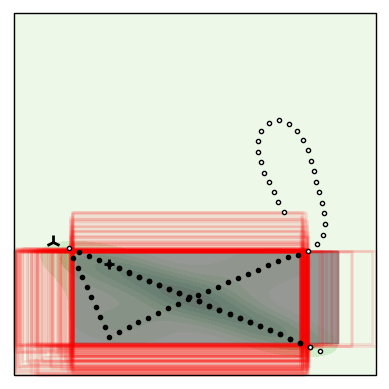

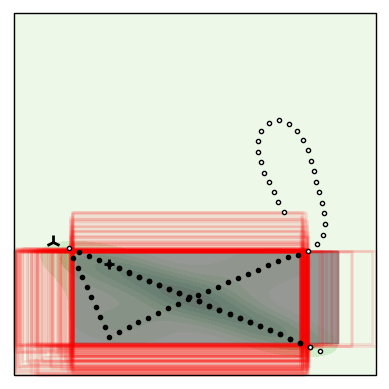

In [ ]:
env = BoxGym(seed=1, sensor_box_size=0.0002, num_sensor_samples=1, max_velocity=0.3, inference_num=100, use_pos_thresh=1)
obs = env.reset()  # Reset and re-randomize the environment

num_tsteps = 100  # Number of total time steps for the experiment
for t in range(num_tsteps):
    # Plan action
    action = env.plan(obs)

    # Execute action, receive new observation/information
    obs, cost, done, trash = env.step(action)  # cost is the variance of the predicted boxes

    # Visualize the environment
    env.render(mode='notebook')   # Choose mode='gui' if you are writing a local python script

    # If the cost is lower than predefined threshold, task is successful
    if done:
        print(f'success in {t} steps!')
        break